<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/SIMULACI%C3%93_A/angle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

lent(x_t)= 8760


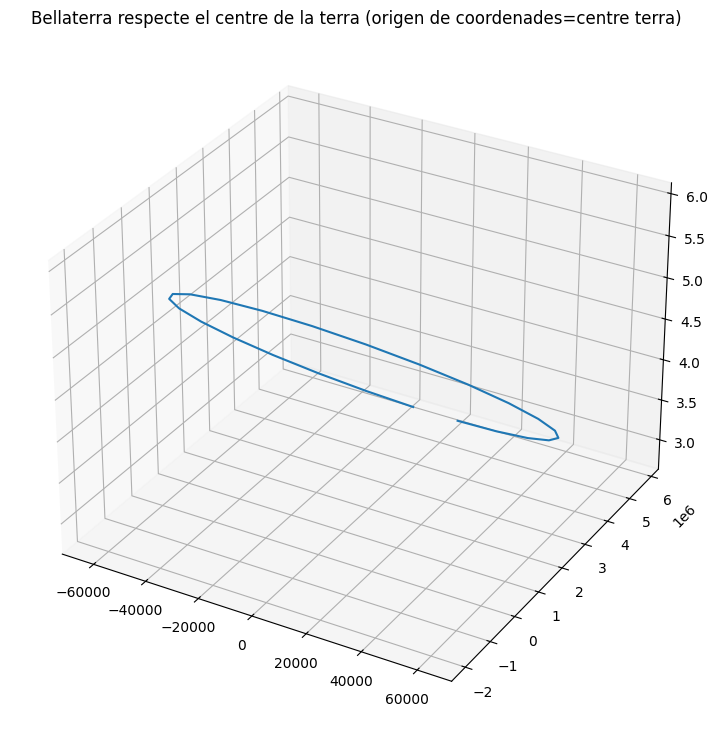

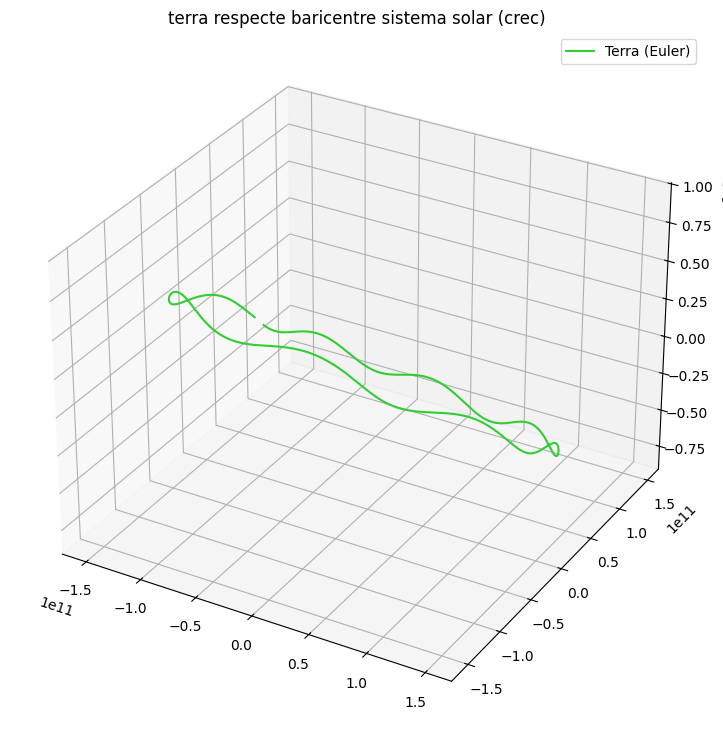

[-0.90583284 -0.8984173  -0.87369619 ... -0.82257516 -0.87263517
 -0.89746596]
0.0 5771224.9159440715 2698630.0171728507
257600233.35896105 -152026718151.6532 8766127.322930027
-0.9058328384687696


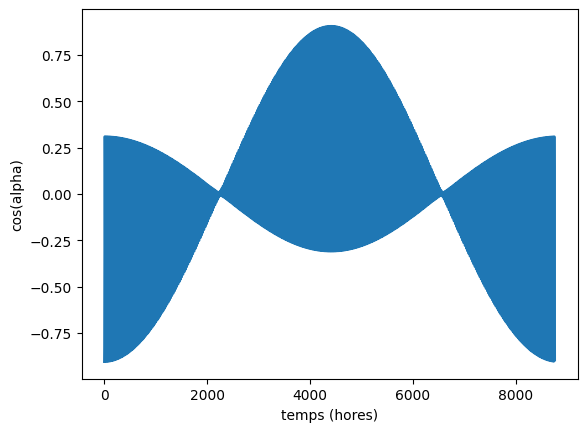

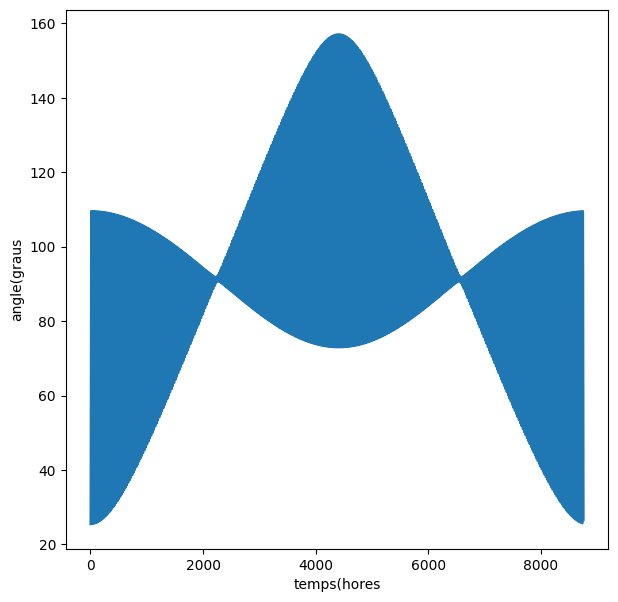

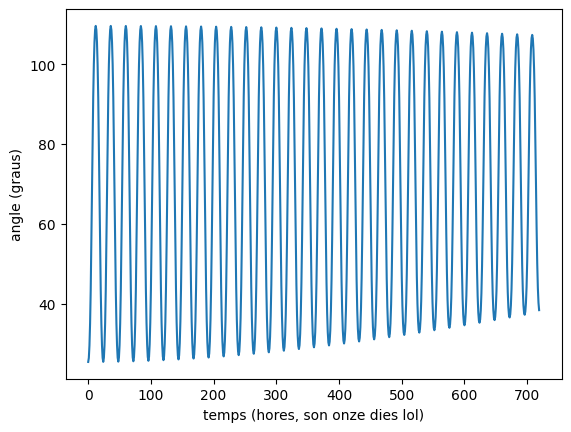

In [ ]:
#en fi ara ve la part que trobem l'angle d'incidencia amb el sol
#suposant que el vector normal al pla de les plaques solars és paral·lel al vector que uneix el centre de la terra amb bellaterra

#necessitem les posicions a la Terra, agafaré durant un any la posició de la Terra cada hora, o sigui 365*24 posicions (de moment Euler que es el que funca)
import numpy as np
import matplotlib.pyplot as plt
import copy
from mpl_toolkits.mplot3d import Axes3D

# Dades en unitats del SI
G= 6.67430e-11
m_sol= 1.98847e30
m_terra= 5.97219e24
m_lluna= 7.349e22
m_mart= 6.4171e23

# Condicions inicials (en cartesianes)
# L'origen és el baricentre del sistema solar
# Format: [x,y,z,vx,vy,vz]
# Inici a les 13:59 del 21 de Juliol del 2025 (solstici d'estiu)
# Això és per el temps central Europeu, per tant hi ha un lleuger error
# Ja que no està a Bellaterra/Barcelona exactament
# Posicions en kilometres i velocitats en km/s

lluna= np.array([-1.223926839954494E+05, -1.526112945830738E+08, 5.512426765490323E+04, 2.865929048320844E+01, 7.673984990113614E-01, 6.367954754048094E-02])
terra= np.array([-4.133776082794621E+05, -1.528302631740358E+08, 3.242787546376139E+04, 2.932642969193051E+01, -7.378251008835289E-02, -1.172300942425906E-03])
sol= np.array([-6.709778526787314E+05, -8.035450223548296E+05, 2.366174814126350E+04, 1.263745636318025E-02, -3.212119035252178E-03, -2.265926685896345E-04])
mart= np.array([-2.457240245390437E+08, -2.253913894859833E+07, 5.577461384361338E+06, 3.057555929366051E+00, -2.206677199548648E+01, -5.372712135532627E-01])

# Normalització
t0= 86400.0            # Temps característic= 1 dia
m0= m_sol              # Massa característica= massa del sol
r0= (G * t0**2 * m0)**(1/3)  # Radi característic

def normalitza(cos6):
  pos = cos6[:3]*(1/r0)*10**3
  vel = cos6[3:]*(t0/r0)*10**3
  return pos, vel

masses= np.array([m_sol/m0, m_terra/m0, m_lluna/m0, m_mart/m0])
pos_sol, vel_sol= normalitza(sol)
pos_terra, vel_terra= normalitza(terra)
pos_lluna, vel_lluna= normalitza(lluna)
pos_mart, vel_mart= normalitza(mart)
posicions= np.array([pos_sol, pos_terra, pos_lluna, pos_mart])
velocitats= np.array([vel_sol, vel_terra, vel_lluna, vel_mart])

def acceleracions(pos, masses): # pos és matriu N files i 3 columnes
    N= len(masses) # Nombre de planetes
    acc= np.zeros_like(pos) # Crea un array amb la mateixa forma que pos però ple de zeros
    for i in range(N):
        for j in range(N):
            if i != j:  # Si i ≠ j, perquè un cos no s'atrau a ell mateix
                diff= pos[j] - pos[i]
                d= np.linalg.norm(diff) # Calcula la norma del vector diferència de posicions
                acc[i]= acc[i] + masses[j] * diff / d**3
    return acc

def euler(pos, vel, masses, h):
    acc_euler= acceleracions(pos, masses)
    vel_nou= vel + h * acc_euler
    pos_nou= pos + h * vel
    return pos_nou, vel_nou

def rk4(pos, vel, masses, h):
    K1= vel
    L1= acceleracions(pos, masses)
    K2= vel + 0.5*h*L1
    L2= acceleracions(pos + 0.5*h*K1, masses)
    K3= vel + 0.5*h*L2
    L3= acceleracions(pos + 0.5*h*K2, masses)
    K4= vel + h*L3
    L4= acceleracions(pos + h*K3, masses)
    pos_nou= pos + (h/6)*(K1 + 2*K2 + 2*K3 + K4)
    vel_nou= vel + (h/6)*(L1 + 2*L2 + 2*L3 + L4)
    return pos_nou, vel_nou

t_f = 365
dt = 1/24
passos = int(t_f/dt) - 1

pos_hist = np.zeros((passos+1, len(masses), 3), dtype=float)
vel_hist = np.zeros((passos+1, len(masses), 3), dtype=float)
pos_hist[0] = posicions
vel_hist[0] = velocitats

for i in range(passos):
  pos_nou, vel_nou = euler(pos_hist[i], vel_hist[i], masses, dt)  # de moment Euler que es el que funca
  pos_hist[i+1] = pos_nou
  vel_hist[i+1] = vel_nou

# Extreure trajectòries
idx_sol = 0
idx_terra = 1

x_t = pos_hist[:, idx_terra, 0]
y_t = pos_hist[:, idx_terra, 1]
z_t = pos_hist[:, idx_terra, 2]

x_s = pos_hist[:, idx_sol, 0]
y_s = pos_hist[:, idx_sol, 1]
z_s = pos_hist[:, idx_sol, 2]

print ("lent(x_t)=", len(x_t))  #per com ho hem fet tenim el vector que uneuix el baricentre del SS amb la Terra i amb el sol
#volem el vector que uneix sol i terra llavors farem el vector baricentre-Terra menys el vector baricentre-Sol

R_t = 6371000 #metres
vel_ang = 2*np.pi/24 # en rad/h
theta = (23.43333333333333*2*np.pi)/360
phi= (41.505833333*2*np.pi)/360

x =  np.array([0])
y =  np.array([R_t*np.sin(theta + phi)])
z = np.array([R_t*np.cos(theta + phi)])

"""
R[sin(θ +ϕ)cos(ωt) + sin(θ)[sin(θ)sin(θ + ϕ) + cos(θ)cos(θ + ϕ)](1−cos(ωt))]
R[cos(θ)sin(θ + ϕ)−sin(θ)cos(θ + ϕ)]sin(ωt)
R[cos(θ + ϕ)cos(ωt) + cos(θ)[sin(θ)sin(θ + ϕ) + cos(θ)cos(θ + ϕ)](1−cos(ωt))]

"""
t = np.linspace(1,23,23)

# aquestes són les coordenades del vector centre terra-bellaterra
x_b = np.concatenate((x,(R_t * np.sin(vel_ang * t))*(np.cos(theta)*np.sin(theta + phi) - np.sin(theta)-np.cos(theta + phi))))
y_b = np.concatenate((y,(np.sin(theta + phi)*np.cos(vel_ang*t) + np.sin(theta)*(np.sin(theta)*np.sin(theta + phi) + np.cos(theta)*np.cos(theta + phi))*(1 - np.cos(vel_ang*t))) * R_t))
z_b = np.concatenate((z,(np.cos(theta + phi)*np.cos(vel_ang*t) + np.cos(theta)*(np.sin(theta)*np.sin(theta + phi) + np.cos(theta)*np.cos(theta + phi))*(1 - np.cos(vel_ang*t))) * R_t))

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_b,y_b,z_b)
ax.set_title("Bellaterra respecte el centre de la terra (origen de coordenades=centre terra)")
plt.show()

x_st = r0 * (x_t - x_s)
y_st = r0 * (y_t - y_s)
z_st = r0 * (z_t - z_s)

X_b = np.array (list(x_b)*365)
Y_b = np.array (list(y_b)*365)
Z_b = np.array (list(z_b)*365)

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_st, y_st, z_st, label="Terra (Euler)", color="limegreen")
# ax.plot(x_b,y_b,z_b, color="blue", label="vector bellaterra respecte el centre de la terra") no cal, no?
ax.set_title("terra respecte baricentre sistema solar (crec)")
plt.legend()
plt.show()


mod_t = np.sqrt(x_st**2 + y_st**2 + z_st**2)
mod_b = np.sqrt(x_b**2 + y_b**2 + z_b**2)
Mod_b = np.array(list(mod_b) * 365)

cos_llista = (X_b * x_st + Y_b * y_st + Z_b * z_st)/(Mod_b * mod_t)
cos_llista = np.clip(cos_llista, -1.0, 1.0)  # per evitar merdes numeriques amb arccos

print(cos_llista)

temps = np.linspace(0,8759,8760)

theta_llista = np.pi - np.arccos(cos_llista)

print(X_b[0],Y_b[0],Z_b[0])
print(x_st[0],y_st[0],z_st[0])

print((X_b[0]*x_st[0]+Y_b[0]*y_st[0]+Z_b[0]*z_st[0])/(np.sqrt(X_b[0]**2+Y_b[0]**2+Z_b[0]**2)*np.sqrt(x_st[0]**2 + y_st[0]**2+ z_st[0]**2)))
plt.plot (temps,cos_llista)
plt.ylabel("cos(alpha)")
plt.xlabel("temps (hores)")
plt.show()

fig = plt.figure(figsize=(7,7)) # Aquesta figura estava a (20,20) però m'ha agobiat vale
plt.plot(temps,theta_llista*365/(2*np.pi))
plt.ylabel("angle(graus")
plt.xlabel("temps(hores")
plt.show()

plt.plot(np.linspace(0,719,720),theta_llista[slice(720)]*365/(2*np.pi))
plt.ylabel("angle (graus)")
plt.xlabel("temps (hores, son onze dies lol)")
plt.show()
#ara ve la part que recordem el producte escalar: mod(v)*mod(u)cos(theta)=v*u

#nota mental aquest producte ens dona l'angle que formen dos vectors amb el mateix origen, si ens fixem nosaltres volem el complementari a aquest, és a dir pi/2 - theta, lol
